<b> T5 Data Science Bootcamp</b>

 <img src="logo.png"  width=800 height=800/>

By: Amirah Alotaibi ,Alanoud Alhussain ,Amal Altamran ,Batoul AlOsaimi ,Shroaq Abdullah ,Norah Alqahtani and Asma Alsulami


## Introduction:

Image caption Generator is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Automatic generation of an image description requires both computer vision and natural language processing techniques. And from this point we decide to help people with disabilities as well as early childhood education By doing image caption English and Arabic and transformed to voice using artificial intelligence technology so, their lives can be improved.


## Table of Contents:

<li><a id='Libraries'> Libraries</a></li>
<li><a id='1. load data'> 1. load data</a></li>
<li><a id=' 2. Pre-Processing the captions'>2.Pre-Processing the captions</a></li>
<li><a id='3.Pre-Processing the images'>3.Pre-Processing the images</a></li>
<li><a id='4. Create the train & test data '>4. Create the train & test data  </a></li>
<li><a id='5. transfer learning'>5. transfer learning</a></li>
<li><a id='6. Extract the features from images'>6. Extract the features from images</a></li>
<li><a id='7.Model Building'>7. Model Building</a></li>
<li><a id='8. Model Evaluation'>8. Model Evaluation</a></li>
<li><a id='9.Convert Text-to-speech'>9.Convert Text-to-speech</a></li>


In [1]:
#Import all the required libraries
import os, glob
from glob import glob
import pickle
from sys import getsizeof

import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Layer, Dense, Embedding, GRU
from tensorflow.nn import relu, tanh, softmax

import matplotlib.pyplot as plt

from nltk.translate.bleu_score import sentence_bleu

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
images = '/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/Flicker8k_Dataset'

all_imgs = glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
all_imgs[0]

'/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/Flicker8k_Dataset/2387197355_237f6f41ee.jpg'

In [4]:
def plotImage(images, captions, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        img = image[image.rfind("/")+1:]
        cap = captions[captions['image'] == img].iloc[:1,1].values[0] # get the first caption
        
        ax.set_title(cap)
        ax.imshow(io.imread(image), cmap)

In [5]:
captions = pd.read_csv("/Users/AAHMT/Downloads/captions.txt")
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


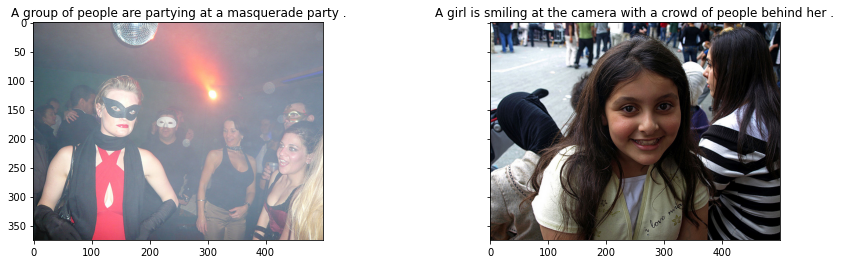

In [6]:
plotImage(all_imgs[0:2], captions)

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
df = captions.copy()
df.columns = ['ID','Captions']

df['Path'] = images + "/" + df['ID']

all_img_id= df['ID']
all_img_vector= df['Path']
annotations= df['Captions']

df

,ID,Captions,Path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...


> in cells bellow gave id nummber for each single word in captions in the dataset to make it easer to learn in the model vocabs is the dataframe that contain tis information

In [8]:
def get_vocab(captions):
    vocabs = map(lambda caption: re.split("\W+", caption.lower()), captions)
    return (word for vocab in vocabs for word in vocab if word != "")

In [9]:
#Create the vocabulary & the counter for the captions

vocabulary= list(get_vocab(df.Captions))

val_count=Counter(vocabulary)
print(val_count['a'])
print(val_count['start'])

62992
9


In [10]:
#convert to dataframe
vocabs = pd.DataFrame.from_dict(val_count, orient='index').reset_index()
vocabs.columns = ['word','count']
vocabs = vocabs.sort_values(by='count', ascending=False)
vocabs.head()

,word,count
0,a,62992
2,in,18986
21,the,18419
37,on,10745
5,is,9345


> in the cell bellow a bar chart that show how many times each word rpeated in the dataset


Text(0, 0.5, 'Count')

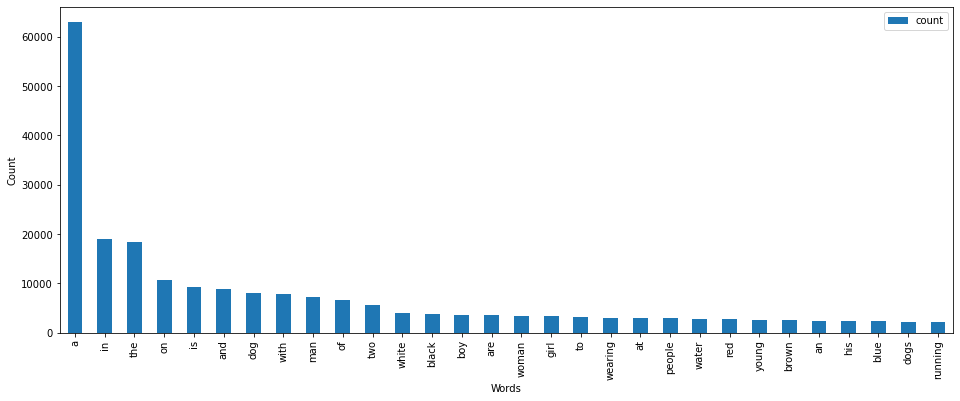

In [11]:
plt.rcParams["figure.figsize"] = [16, 6]

vocabs.head(30).plot(kind='bar', x='word', y='count')

plt.xlabel("Words")
plt.ylabel("Count")

> here we added start and end before and affter each caption as part of preprossesing and data cleaning


In [12]:
df['Captions'] = "<start> " + df['Captions'] + " <end>"
annotations = df['Captions']

all_img_path= list(df['Path'])

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [13]:
df.head()

,ID,Captions,Path
0,1000268201_693b08cb0e.jpg,<start> A child in a pink dress is climbing up...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
1,1000268201_693b08cb0e.jpg,<start> A girl going into a wooden building . ...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
2,1000268201_693b08cb0e.jpg,<start> A little girl climbing into a wooden p...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
3,1000268201_693b08cb0e.jpg,<start> A little girl climbing the stairs to h...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...
4,1000268201_693b08cb0e.jpg,<start> A little girl in a pink dress going in...,/Users/AAHMT/Desktop/archive/Flickr8k_Dataset/...


## Pre-Processing the captions
1.We will tokenize the captions and build the vocabulary which will be used to generate the caption for the image.

2.We will keep only 5000 most used words and replace all other words with the unknown token "UNK".

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences vectors to be the same length as the longest one.

In [14]:
# create the tokenizer
def tokenize(captions):
    special_chars = '`~"@#$%&()[]{}!*+=.,/:;?\^-_| '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,
                                                  oov_token="UNK",
                                                  filters=special_chars)
    tokenizer.fit_on_texts(captions)   
   
    return tokenizer 


img_captions, img_name_vector = shuffle(annotations, all_img_vector, random_state=42)
tokenizer = tokenize(img_captions)

In [15]:
# Create word-to-index and index-to-word mapping

def word_2_index(word):
    return tokenizer.word_index[word]
    
def index_2_word(index):
    return tokenizer.index_word[index]

print(index_2_word(10))
print(word_2_index('dog'))

dog
10


Text(0, 0.5, 'Count')

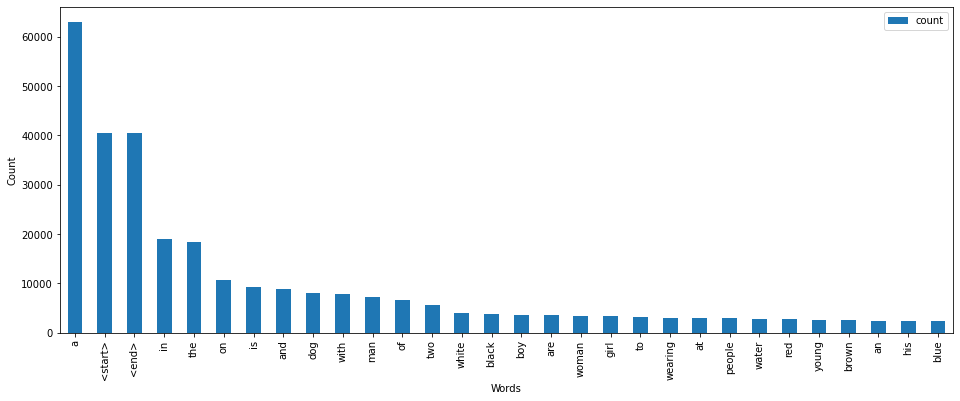

In [16]:
import operator
plt.rcParams["figure.figsize"] = [16, 6]

words = sorted(tokenizer.word_counts.items(), key=operator.itemgetter(1),reverse=True)
vocabs = pd.DataFrame(words)
vocabs.columns = ['word','count']
vocabs.head(30).plot(kind='bar', x='word', y='count')

plt.xlabel("Words")
plt.ylabel("Count")

In [17]:
caption_sequences = tokenizer.texts_to_sequences(img_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(caption_sequences, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-Processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [18]:
def preprocess_the_image(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, imagePath

allImages = sorted(set(img_name_vector))

train_dataset = tf.data.Dataset.from_tensor_slices(allImages)
train_dataset = train_dataset.map(preprocess_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

2021-12-06 17:54:53.441377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create the train & test data 
1. We will combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test split using 80-20 ratio & random state = 42

2. We shuffle and batch while building the dataset

3. The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4. The shape of each caption in the dataset after building should be (batch_size, max_len)


In [19]:
image_train, image_test, captions_train, captions_test = train_test_split(img_name_vector,
                                                                          cap_vector, 
                                                                          test_size=0.2, 
                                                                          random_state=42)

In [20]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 299, 299, 3)
(64,)


In [21]:
img_to_cap_vector = collections.defaultdict(list)

for img,cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

In [22]:
def vector_to_sentence(caplist):
    captions_word =[]
    for captions in caplist:
        list_caption = list(captions)

        captions_word.append(' '.join(tokenizer.index_word[i] for i in list_caption))
    return captions_word

## Load the pre-trained Imagenet weights of Inception net V3

1.We will extract the features of the mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this pre-trained NN's layer is 8x8x2048.

In [23]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output # take only the last layer

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Extract the features from images

In [24]:
from tqdm import tqdm

all_features_dict = {}
for img,path in tqdm(train_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        file_name = p.numpy().decode("utf-8")
        all_features_dict[file_name] = bf.numpy()

100%|█████████████████████████████████████████| 127/127 [18:30<00:00,  8.75s/it]


## Shuffle the processed Train and Test Datasets

In [25]:
def feature_tensor(img_name, cap):
    img_tensor = all_features_dict[img_name.decode("utf-8")]
    return img_tensor, cap

BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = tf.data.Dataset.from_tensor_slices((image_train, captions_train))

train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
                                   feature_tensor, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.data.Dataset.from_tensor_slices((image_test, captions_test))

test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          feature_tensor, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
train_img_batch, train_cap_batch = next(iter(train_dataset))
print(train_img_batch.shape)
print(train_cap_batch.shape)

(64, 64, 2048)
(64, 39)


In [27]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 39)


## Model Building
Build the Encoder, Attention model & Decoder

In [28]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE 
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [29]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim)
        
    def call(self, features):
        features = self.dense(features)
        features = relu(features)
        
        return features

In [30]:
encoder=Encoder(embedding_dim)

### Attention model

In [31]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        self.units = units

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        attention_weights = softmax(score, axis = 1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector,axis = 1)

        return context_vector, attention_weights

### Decoder

In [32]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = Embedding(vocab_size,embed_dim)
        self.gru = GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = Dense(self.units)
        self.d2 = Dense(vocab_size)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.embed(x)
        embed = tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)
        output,state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [33]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [34]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))
print('Predcitions shape from Decoder: {}'.format(predictions.shape))
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
- We will use Adam optimizer with default learning rate, however we can try learning rate hyper parameter tuning incase we can't reach the global minima
- Cross entropy loss metrics in order to calculate the train and test loss

In [35]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction='none') #define your loss object
metrics = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [36]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Create checkpoints during model traning

In [37]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [38]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Override the tensorflow training/test steps
- override with Encoder, Attention model, Decoder steps

In [39]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor,training =True)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    metrics(loss)    
        
    return loss, total_loss

In [40]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            predicted_id = tf.argmax(predictions[0])
            dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)
   
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [41]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss

    avg_test_loss = total_loss/int(target.shape[1])
    
    return avg_test_loss

In [45]:
import datetime,time

loss_plot = []
test_loss_plot = []
EPOCHS = 20 
# 20 epoches should be enough
# we can try with higher number of epochs in order to get higher accuracy 
# but it might decrease as well so we can do check pointing and find the best model

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss = total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()


  0%|                                                    | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.789, & test loss is 6.419
Time taken for 1 epoch 1982.668569803238 sec

Test loss has been reduced from 100.000 to 6.419


 10%|███▊                                  | 2/20 [1:06:20<9:57:27, 1991.50s/it]

For epoch: 2, the train loss is 0.743, & test loss is 6.542
Time taken for 1 epoch 1997.0622191429138 sec



 15%|█████▋                                | 3/20 [1:41:11<9:37:06, 2036.85s/it]

For epoch: 3, the train loss is 0.700, & test loss is 6.695
Time taken for 1 epoch 2090.8162789344788 sec



 20%|███████▌                              | 4/20 [2:18:53<9:26:50, 2125.66s/it]

For epoch: 4, the train loss is 0.662, & test loss is 6.837
Time taken for 1 epoch 2261.793664932251 sec



 25%|█████████▌                            | 5/20 [3:03:29<9:41:05, 2324.34s/it]

For epoch: 5, the train loss is 0.625, & test loss is 6.942
Time taken for 1 epoch 2676.6140100955963 sec



 30%|██████████▌                        | 6/20 [10:02:00<39:10:02, 10071.63s/it]

For epoch: 6, the train loss is 0.592, & test loss is 7.199
Time taken for 1 epoch 25110.43258190155 sec



 35%|████████████▌                       | 7/20 [10:34:35<26:47:15, 7418.09s/it]

For epoch: 7, the train loss is 0.560, & test loss is 7.246
Time taken for 1 epoch 1954.9221470355988 sec



 40%|██████████████▍                     | 8/20 [11:02:09<18:36:37, 5583.10s/it]

For epoch: 8, the train loss is 0.531, & test loss is 7.485
Time taken for 1 epoch 1654.0694041252136 sec



 45%|████████████████▏                   | 9/20 [11:30:57<13:22:37, 4377.98s/it]

For epoch: 9, the train loss is 0.503, & test loss is 7.534
Time taken for 1 epoch 1728.1319160461426 sec



 50%|█████████████████▌                 | 10/20 [12:53:03<12:37:53, 4547.31s/it]

For epoch: 10, the train loss is 0.478, & test loss is 8.028
Time taken for 1 epoch 4926.445486068726 sec



 55%|███████████████████▊                | 11/20 [13:26:41<9:25:56, 3772.96s/it]

For epoch: 11, the train loss is 0.455, & test loss is 8.071
Time taken for 1 epoch 2017.1932771205902 sec



 60%|█████████████████████▌              | 12/20 [14:01:03<7:13:40, 3252.55s/it]

For epoch: 12, the train loss is 0.433, & test loss is 8.340
Time taken for 1 epoch 2062.2591309547424 sec



 65%|███████████████████████▍            | 13/20 [14:31:41<5:29:28, 2824.01s/it]

For epoch: 13, the train loss is 0.412, & test loss is 8.619
Time taken for 1 epoch 1837.9024040699005 sec



 70%|█████████████████████████▏          | 14/20 [15:03:41<4:15:06, 2551.10s/it]

For epoch: 14, the train loss is 0.396, & test loss is 8.854
Time taken for 1 epoch 1920.4895370006561 sec



 75%|███████████████████████████         | 15/20 [15:33:08<3:12:53, 2314.78s/it]

For epoch: 15, the train loss is 0.377, & test loss is 9.008
Time taken for 1 epoch 1767.1074857711792 sec



 80%|████████████████████████████▊       | 16/20 [16:02:09<2:22:47, 2141.94s/it]

For epoch: 16, the train loss is 0.361, & test loss is 9.349
Time taken for 1 epoch 1740.5519468784332 sec



 85%|██████████████████████████████▌     | 17/20 [16:31:06<1:41:00, 2020.26s/it]

For epoch: 17, the train loss is 0.347, & test loss is 9.521
Time taken for 1 epoch 1737.2854599952698 sec



 90%|████████████████████████████████▍   | 18/20 [16:59:57<1:04:26, 1933.27s/it]

For epoch: 18, the train loss is 0.334, & test loss is 9.842
Time taken for 1 epoch 1730.7509529590607 sec



 95%|████████████████████████████████████  | 19/20 [17:28:50<31:13, 1873.06s/it]

For epoch: 19, the train loss is 0.320, & test loss is 10.219
Time taken for 1 epoch 1732.7843430042267 sec



100%|██████████████████████████████████████| 20/20 [17:57:50<00:00, 3233.54s/it]

For epoch: 20, the train loss is 0.309, & test loss is 10.276
Time taken for 1 epoch 1740.5764422416687 sec



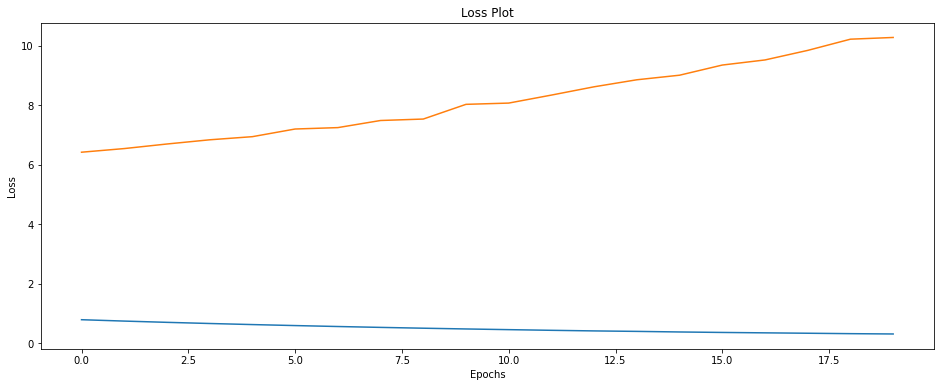

In [46]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1. Define the evaluation function using greedy search
2. Test it on a sample data using BLEU score

### Greedy Search

In [531]:
def evaluate(image):
    max_length = cap_vector.shape[1]
    attention_features_shape = 64
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    
    pimg, path = preprocess_the_image(image)

    temp_input = tf.expand_dims(pimg, 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden) # get the output from decoder
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


In [532]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [533]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 0
Real Caption: Two men at the party.
Prediction Caption: a man glasses and another man


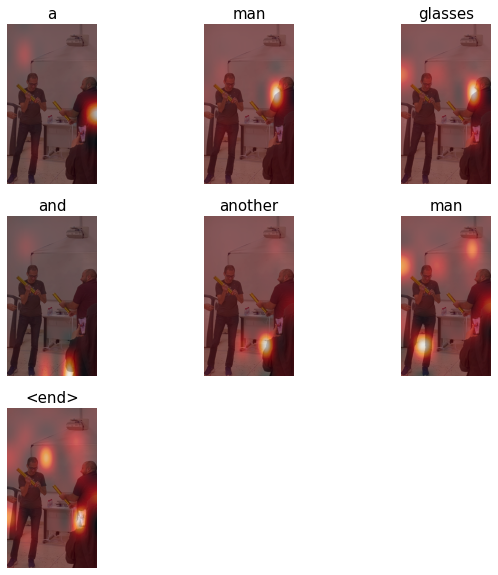

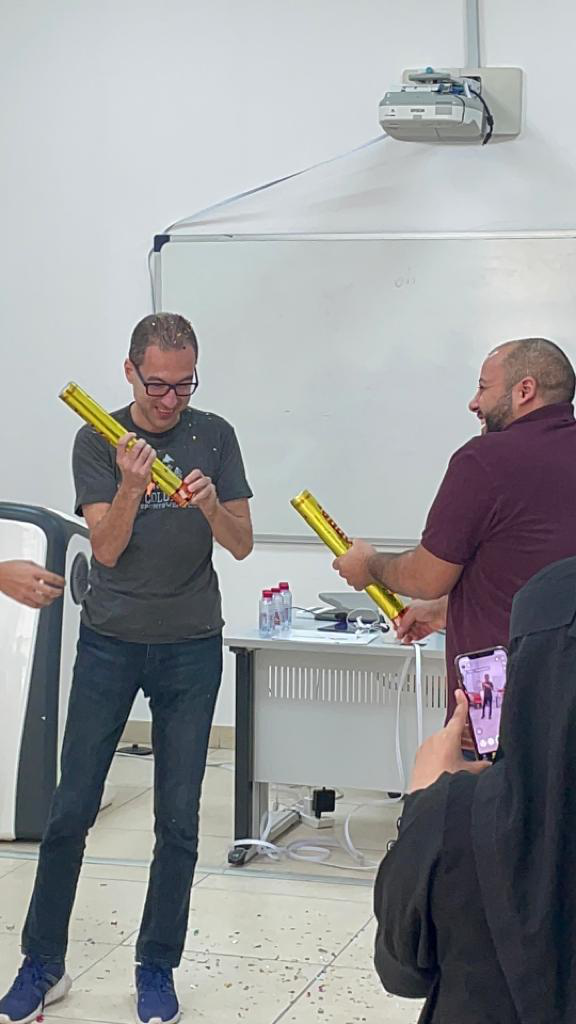

In [539]:
test_image = '/Users/AAHMT/Desktop/PHOTO-2021-12-07-13-17-36.jpg'
real_caption = '<start> Two men at the party. <end>'

result, attention_plot, pred_test = evaluate(test_image)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0,0,1,0))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

## convert Text-to-speech

- pyttsx3 library can be used to read the predicted caption for blind person

In [542]:
#!pip install pyttsx3

In [519]:
import pyttsx3
engine = pyttsx3.init()
engine.say(pred_caption)
engine.runAndWait()